<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Machine Learning Para Aplicações Biomédicas</font>
## <font color='blue'>Projeto 6</font>
## <font color='blue'>Interações Proteína-Proteína (PPIs) com Graph Neural Networks</font>

<img src="imagens/grafo.png" width="600" />

As Interações Proteína-Proteína (PPIs) referem-se às conexões físicas e funcionais que ocorrem entre duas ou mais proteínas dentro de uma célula. Essas interações são essenciais para praticamente todos os processos biológicos, incluindo a regulação de funções celulares, sinalização, metabolismo e a formação de estruturas celulares.

De forma simples, imagine que as proteínas são peças de um quebra-cabeça que se encaixam entre si para executar tarefas específicas. Quando duas ou mais proteínas se ligam, elas podem ativar, inibir ou modificar uma à outra, permitindo que a célula responda adequadamente a diferentes estímulos e mantenha seu funcionamento correto. A compreensão das PPIs é importante, pois desvios nessas interações podem levar a doenças, como o câncer ou outras condições genéticas.

## Pacotes Python Usados no Projeto

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

O procedimento de instalação de pacotes e dependências está no arquivo LEIAME.txt

https://networkx.org/

In [2]:
#!pip install -q networkx

In [3]:
# Imports
import time
import torch
import scipy
import sklearn
import matplotlib
import networkx as nx
import numpy as np
import torch.nn.functional as F
from torch import nn
from scipy import sparse as sp
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

In [4]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Funções Para Carga dos Dados no Formato de Grafo

In [5]:
# Define a função que carrega os dados a partir de um arquivo edgelist
def dsa_carrega_dados(filename = 'yeast.edgelist'):
    
    # Lê o arquivo edgelist e cria um grafo usando a biblioteca NetworkX
    graph = nx.read_edgelist(filename)
    
    # Gera a matriz de adjacência a partir do grafo
    adjacency = nx.adjacency_matrix(graph)
    
    # Retorna o grafo e a matriz de adjacência
    return graph, adjacency

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
Uma matriz de adjacência é uma representação matemática de um grafo que descreve as conexões entre seus nós. Em um grafo, os nós representam entidades e as arestas (conexões) representam relacionamentos entre esses nós. A matriz de adjacência é uma forma de representar essas conexões de maneira tabular, usando uma matriz.

In [6]:
# Define a função que faz um subsample do grafo, limitando o número de nós
def dsa_subsample_graph(graph, max_nodes = 1000):
    
    # Seleciona um subconjunto aleatório de nós do grafo e cria um subgrafo com esses nós
    graph = graph.subgraph(np.random.choice(graph.nodes(), max_nodes, replace = False)).copy()
    
    # Mantém apenas o maior componente conectado do subgrafo
    graph = graph.subgraph(sorted(nx.connected_components(graph), key = len, reverse = True)[0]).copy()
    
    # Remove nós isolados (sem arestas) do subgrafo
    graph.remove_nodes_from(list(nx.isolates(graph)))
    
    # Gera a matriz de adjacência a partir do subgrafo
    adjacency = nx.adjacency_matrix(graph)
    
    # Retorna o subgrafo e a matriz de adjacência
    return graph, adjacency

In [7]:
# Define a função que obtém o índice das arestas a partir da matriz de adjacência
def dsa_get_edge_index(adjacency):
    
    # Mantém apenas a parte superior da matriz de adjacência para evitar duplicidade de arestas
    adjacency = sp.triu(adjacency)
    
    # Retorna as coordenadas dos elementos não nulos (as arestas) na matriz de adjacência
    return np.stack(adjacency.nonzero(), axis = 0)

## Carregando os Dados

In [8]:
# Extrai grafo e matriz de adjacências
graph, adjacency = dsa_carrega_dados('yeast.edgelist')

In [9]:
# Cada nó é uma proteína
graph.nodes

NodeView(('YLR418C', 'YOL145C', 'YOR123C', 'YBR279W', 'YML069W', 'YGL244W', 'YGL207W', 'YER164W', 'YIL035C', 'YOR061W', 'YGL019W', 'YOR039W', 'YDL209C', 'YDR364C', 'YMR213W', 'YLR117C', 'YGR278W', 'YGL128C', 'YBR065C', 'YJR050W', 'YPL213W', 'YLL036C', 'YGL120C', 'YAL032C', 'YPL151C', 'YHR165C', 'YER029C', 'YGR074W', 'YLR147C', 'YPR101W', 'YKL173W', 'YDR416W', 'YGR129W', 'YKL095W', 'YKR022C', 'YLR424W', 'YNL245C', 'YIR010W', 'YBR211C', 'YDR254W', 'YPL018W', 'YLR381W', 'YJR135C', 'YAL034W-A', 'YDR383C', 'YPL233W', 'YGR179C', 'YJL091C', 'YHR019C', 'YCL061C', 'YOR254C', 'YDR170C', 'YJR100C', 'YNL124W', 'YLR175W', 'YJL072C', 'YDR013W', 'YOL146W', 'YDR489W', 'YDL140C', 'YIL021W', 'YGR116W', 'YGR186W', 'YGR005C', 'YPL129W', 'YML010W', 'YOR151C', 'YPL063W', 'YMR203W', 'YDR288W', 'YEL019C', 'YLR007W', 'YDL105W', 'YLR383W', 'YOL034W', 'YDR365C', 'YDR299W', 'YJL033W', 'YER127W', 'YOR310C', 'YHR196W', 'YGR145W', 'YFR003C', 'YER133W', 'YKL193C', 'YGR002C', 'YJL081C', 'YLR384C', 'YOR244W', 'YDR190C'

In [10]:
# A matriz de adjacência indica os relacionamentos entre os nós
# É uma matriz densa com valor 1 indicando se existe relação entre os nós
adjacency.data.view()

array([1, 1, 1, ..., 1, 1, 1], shape=(1062675,))

In [11]:
# Cria uma amostra de até 1000 nós
graph, adjacency = dsa_subsample_graph(graph, max_nodes = 1000)

In [12]:
# Obtém o índice de arestas
edge_index = dsa_get_edge_index(adjacency)

In [13]:
print(graph)

Graph with 916 nodes and 11844 edges


In [14]:
# Extrai o número de nós e número de arestas
N_NODES = adjacency.shape[0]
N_EDGES = edge_index.shape[1]

In [15]:
N_NODES

916

In [16]:
N_EDGES

11844

## Data Splitting de Grafos

Agora, vamos dividir os dados em conjuntos de treinamento, validação e teste. 

Para criar os conjuntos de validação e teste, selecionaremos algumas arestas existentes para criar exemplos positivos e, em seguida, amostraremos algumas arestas ausentes (verificando se elas não estão no grafo) para ter exemplos negativos.

Então, para cada conjunto:

1. Amostramos X% das arestas como exemplos positivos.
2. Criamos exemplos negativos selecionando pares de nós que não estão conectados no grafo original, tantos quantos tivermos arestas positivas.

Finalmente, o conjunto de treinamento consistirá no restante das arestas. Para evitar o treinamento nas arestas de validação e teste, também construímos uma máscara para a matriz de adjacência que indicará se usamos uma determinada aresta durante o treinamento.

No final teremos essencialmente isso em cada amostra:

- Aresta está no grafo (classe positiva)
- Aresta não está no grafo (classe negativa)

E assim vamos transformar o problema em aprendizado supervisionado para classificação binária. O modelo GNN vai ser treinado com dados de arestas e nós e então avaliaremos o modelo com arestas positivas e negativas (ou seja, arestas que estão ou não no grafo).

In [17]:
# Porcentagem de arestas a serem usadas para o conjunto de validação e teste
TEST_EDGE_RATIO = 0.1  

Veja a descrição completa da função abaixo no videobook do Capítulo 14 do curso.

In [18]:
# Define a função que divide as arestas do grafo em conjuntos de treino, validação e teste,
# criando ainda classe positiva e negativa
def dsa_split_graph_edges(adj, edge_index, test_edge_ratio = TEST_EDGE_RATIO):

    # Calcula o número de arestas para validação e teste com base na proporção especificada
    n_valid = n_test = int(N_EDGES * test_edge_ratio)
    
    # Separa as arestas de validação
    valid_edges = edge_index[:, :n_valid]
    
    # Separa as arestas de teste
    test_edges = edge_index[:, n_valid:n_valid + n_test]
    
    # Define o conjunto de arestas de treino com o restante das arestas
    train_edges = edge_index[:, n_valid + n_test:]

    # Inicializa a lista para armazenar arestas negativas
    neg_edge = []
    
    # Define o número de arestas negativas a serem geradas
    num_neg = n_valid + n_test
    
    # Gera arestas negativas aleatórias até alcançar o número necessário
    while len(neg_edge) < num_neg:
        
        i, j = np.random.randint(0, N_NODES, size = (2,))
        
        # Verifica se os nós são diferentes, não estão conectados e se a aresta já não foi gerada
        if i != j and adj[i, j] == 0 and [i, j] not in neg_edge:
            neg_edge.append([i, j])
    
    # Converte a lista de arestas negativas de validação em array e a transpõe
    valid_edges_neg = np.array(neg_edge[:n_valid]).T
    
    # Converte a lista de arestas negativas de teste em array e a transpõe
    test_edges_neg = np.array(neg_edge[n_valid:]).T

    # Cria a matriz de adjacência para o conjunto de treino a partir das arestas de treino
    adj_train = sp.csr_matrix((np.ones(train_edges.shape[1]), train_edges), shape = adj.shape)
    
    # Ajusta a matriz de adjacência para incluir as arestas na direção oposta e remove autoconexões
    adj_train = adj_train + adj_train.T - sp.diags(adj_train.diagonal(), dtype = int)
    
    # Recalcula os índices das arestas de treino com base na nova matriz de adjacência
    train_edges = dsa_get_edge_index(adj_train)
    
    # Cria uma máscara para indicar as arestas de treino (true para treino, false para validação e teste)
    train_mask = np.ones(adj_train.shape, dtype = bool)
    
    # Atualiza a máscara de treino para remover as arestas de validação, teste e suas contrapartes negativas
    # também remove a direção reversa
    for edges in [valid_edges, valid_edges_neg, test_edges, test_edges_neg]:
        i += (edges[0] == edges[1]).sum()
        train_mask[edges[0], edges[1]] = False
        train_mask[edges[1], edges[0]] = False  

    # Retorna a matriz de adjacência de treino, as arestas de treino, a máscara de treino,
    # e os conjuntos de arestas de validação, validação negativa, teste e teste negativo
    return adj_train, train_edges, train_mask, valid_edges, valid_edges_neg, test_edges, test_edges_neg

**Arestas Positivas**: São as conexões que existem no grafo original, representando interações reais entre nós. No contexto de aprendizado de máquina em grafos, estas são as conexões que o modelo deve aprender a prever corretamente.

**Arestas Negativas**: São conexões que não existem no grafo. Elas são geradas aleatoriamente entre pares de nós que não estão conectados no grafo original. Essas arestas são usadas para ensinar o modelo a reconhecer e evitar previsões de conexões inexistentes.

In [19]:
# Gera as amostras
adj_train, train_edges, train_mask, valid_edges, valid_edges_neg, test_edges, test_edges_neg = dsa_split_graph_edges(adjacency, edge_index, TEST_EDGE_RATIO)


In [20]:
print(f"Divisão dos Edges (Arestas) em:\n treino: {train_edges.shape[1]}\n validação: {valid_edges.shape[1]}\n teste: {test_edges.shape[1]}")

Divisão dos Edges (Arestas) em:
 treino: 9476
 validação: 1184
 teste: 1184


In [21]:
# Amostras positivas de treino
n_pos_edge = adj_train[train_mask].sum()

In [22]:
# Amostras negativas de treino
n_neg_edge = (1 - adj_train.todense())[train_mask].sum()

In [23]:
# Calculamos a taxa das arestas positivas
# Usaremos isso como peso para compensar o desequilíbrio
pos_weight = n_neg_edge / n_pos_edge  

In [24]:
print(f"Taxa de Edges Negativo/Positivo: {pos_weight:.2f}")

Taxa de Edges Negativo/Positivo: 43.26


## Visualizando os Grafos de Treino, Validação e Teste

Vamos visualizar uma parte dos dados do grafo. Note que amostramos nós aleatoriamente para esta visualização, então é possível que acabemos com mais de um único componente conectado, mesmo que o grafo completo tenha apenas um.

In [25]:
# Número de nós a serem mantidos para a visualização
N = 200  

In [26]:
nodelist = np.random.permutation(graph.nodes())[:N]

O que a expressão acima faz:

- Embaralha a lista de nós do grafo (graph.nodes()).
- Seleciona os primeiros 𝑁 nós da lista embaralhada.

In [27]:
# Cria o sub-grafo
subgraph = graph.subgraph(nodelist).copy()

In [28]:
# Remove auto-loops para visualização
subgraph.remove_edges_from(list(nx.selfloop_edges(subgraph)))  

In [29]:
# Remove nós isolados para visualização
subgraph.remove_nodes_from(list(nx.isolates(subgraph)))  

In [30]:
print(subgraph)

Graph with 169 nodes and 454 edges


In [31]:
# A expressão abaixo é usada para calcular as posições dos nós de um grafo (subgraph) para fins de visualização, 
# utilizando o algoritmo Spring Layout, que é uma forma comum de desenhar grafos de maneira esteticamente agradável
pos = nx.spring_layout(subgraph, iterations = 100)

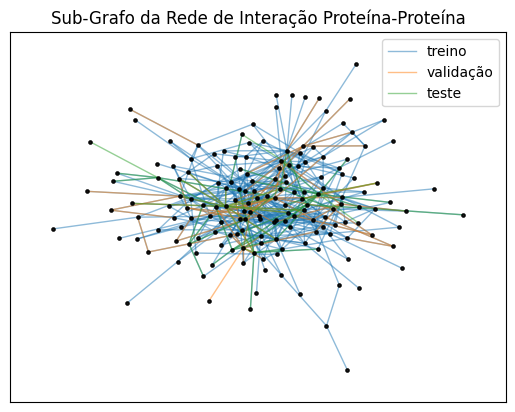

In [32]:
# Cria uma figura e um eixo para o gráfico (aqui é o gráfico que vai mostrar o grafo)
fig, ax = plt.subplots(1, 1)

# Define o título do gráfico
ax.set_title('Sub-Grafo da Rede de Interação Proteína-Proteína')

# Itera sobre os conjuntos de arestas (treino, validação e teste) e suas respectivas cores
for edge_set, color in [(train_edges, 'C0'), (valid_edges, 'C1'), (test_edges, 'C2')]:
    
    # Obtém a lista de arestas correspondentes ao conjunto atual
    edgelist = subgraph.edges(np.array(graph.nodes())[edge_set[0]])
    
    # Desenha o subgrafo com as arestas selecionadas, utilizando a cor especificada
    nx.draw_networkx(subgraph, 
                     pos, 
                     edgelist = edgelist, 
                     ax = ax, 
                     with_labels = False, 
                     node_size = 5, 
                     node_color = 'black', 
                     edge_color = color, 
                     width = 1., 
                     alpha = 0.5)

# Adiciona uma legenda ao gráfico para diferenciar as arestas de treino, validação e teste
ax.legend([Line2D([], 
                  [], 
                  color = c, 
                  linewidth = 1., 
                  alpha = 0.5) for c in ('C0', 'C1', 'C2')], ['treino', 'validação', 'teste']);

## Preparando os Dados

Agora, podemos preparar os dados para o PyTorch. O modelo toma como entrada os embeddings de nós e a matriz de adjacência, e irá prever arestas.

Note que este conjunto de dados não tem nenhum embedding de nós, as únicas informações disponíveis são as interações existentes (as arestas). Então, criaremos manualmente os embeddings para cada nó.

In [33]:
# Define a função que converte uma matriz esparsa do scipy para um tensor esparso do PyTorch
def dsa_sparse_array_to_tensor(adj):
    
    # Converte uma matriz esparsa do scipy para um tensor esparso do PyTorch.
    # Converte a matriz esparsa para o formato COO (Coordinate list)
    adj = adj.tocoo()
    
    # Retorna um tensor esparso do PyTorch criado a partir dos dados da matriz COO
    return torch.sparse_coo_tensor(
        
        # As coordenadas das arestas (linhas e colunas)
        torch.LongTensor(np.vstack((adj.row, adj.col))),  
        
        # Os valores não nulos da matriz
        torch.FloatTensor(adj.data), 
        
        # O tamanho original da matriz
        torch.Size(adj.shape))

In [34]:
# Converte os dados em tensores PyTorch
data = {
    'adj_train': dsa_sparse_array_to_tensor(adj_train).to_dense(), # matriz de adjacência do conjunto de treinamento
    'train_edges': torch.LongTensor(train_edges),                  # índices de arestas no conjunto de treinamento
    'train_mask': torch.BoolTensor(train_mask),                    # máscara booleana de arestas no conjunto de treinamento
    'valid_edges': torch.LongTensor(valid_edges),                  # índices de arestas no conjunto de validação
    'valid_edges_neg': torch.LongTensor(valid_edges_neg),          # índices de arestas negativas no conjunto de validação
    'test_edges': torch.LongTensor(test_edges),                    # índices de arestas no conjunto de teste
    'test_edges_neg': torch.LongTensor(test_edges_neg),            # índices de arestas negativas no conjunto de teste
}

In [35]:
# Incorpora os nós como vetores one-hot. Isso cria a matriz de embeddings!
D_NODES = N_NODES  
data['x_train'] = torch.eye(N_NODES)

In [36]:
# Print 
for key, value in data.items():
    print(f"Matriz: {key}, Shape: {value.shape}")

Matriz: adj_train, Shape: torch.Size([916, 916])
Matriz: train_edges, Shape: torch.Size([2, 9476])
Matriz: train_mask, Shape: torch.Size([916, 916])
Matriz: valid_edges, Shape: torch.Size([2, 1184])
Matriz: valid_edges_neg, Shape: torch.Size([2, 1184])
Matriz: test_edges, Shape: torch.Size([2, 1184])
Matriz: test_edges_neg, Shape: torch.Size([2, 1184])
Matriz: x_train, Shape: torch.Size([916, 916])


In [37]:
# Checagem das dimensões
# Se houver problema uma mensagem será impressa. Caso contrário, tudo pronto para a modelagem.
num_pos_edges = data["train_edges"].shape[1] + data["valid_edges"].shape[1] + data["test_edges"].shape[1]
assert num_pos_edges == N_EDGES, "O número total de arestas nas divisões deve corresponder ao número original de arestas"

## Graph Neural Networks
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
Veja a descrição completa no e-book do Capítulo 15 do curso. Recomendamos ainda este paper:

Graph neural networks: A review of methods and applications

https://arxiv.org/pdf/1812.08434

___

<img src="imagens/gnn1.png" width="600" />

___

<img src="imagens/gnn2.png" width="600" />

### Construindo e Testando a Classe da Graph Convolutional Layer

Comeceçamos implementando camadas para executar convoluções de grafos com agregação de vizinhança simples. Elas serão úteis para construir a parte Deep Graph Encoder de todo o modelo GNN.

<img src="imagens/gnn3.png" width="600" />

Esta é a equação da camada:
$$
\mathbf{h}_v^{(l+1)} = \sigma\left( \mathbf{W}_l \sum_{u\in N(v)} \frac{\mathbf{h}_u^{(l)}}{|N(v)|} + \mathbf{B}_l \mathbf{h}_v^{(l)} \right),
$$

onde $v$ é índice do node, $l$ a camada, $\mathbf{h}$ são as embeddings de nodes, $\sigma$ representa não linearidade, $N(v)$ é o conjunto de vizinhos do nó $v$, e $\mathbf{W}$ e $\mathbf{B}$ são as matrizes de peso treináveis da camada. Ou, em forma de matriz com a matriz de adjacência (corrigido pelo inverso do grau) $\tilde{A}$:

$$
H^{(l+1)} = \sigma\left( \tilde{A}H^{(l)}W_l^\top + H^{(l)}B_l^\top \right).
$$
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
**Nota**: por causa da nossa divisão ingênua de dados e da escassez de conexões no grafo, alguns nós podem não ter vizinhos. Para esses nós, tenha cuidado com a agregação de vizinhança, pois seu grau é 0!

In [38]:
# Classe DSAGraphConv
class DSAGraphConv(nn.Module):

    # Método construtor
    def __init__(self, in_features, out_features, activation = None):
        
        # Inicializa a classe base nn.Module
        super().__init__()
        
        # Define a quantidade de atributos de entrada e saída
        self.in_features = in_features
        self.out_features = out_features

        # Define a matriz de pesos W para a operação de convolução
        self.W = nn.Linear(in_features, out_features, bias = False)
        
        # Define a matriz de pesos B (bias) para a operação de convolução
        self.B = nn.Linear(in_features, out_features, bias = False)

        # Define a função de ativação, se fornecida
        self.activation = activation

    # Método forward
    def forward(self, x, adj):
        
        # Atribui as entradas x (features) e adj (matriz de adjacência)
        X, A = x, adj

        # Obtém o número de nós no grafo
        N = len(A)

        # Calcula o grau de cada nó (soma das conexões para cada nó)
        degrees = A.sum(1)
        
        # Calcula o inverso do grau de cada nó
        degrees_inv = 1 / degrees
        
        # Substitui valores infinitos por zero (para evitar divisões por zero)
        degrees_inv_masked = torch.where(degrees_inv != float('inf'), degrees_inv, 0)
        
        # Calcula A_hat, a matriz de adjacência normalizada
        A_hat = torch.diag(degrees_inv_masked) @ A

        # Aplica a operação de convolução sobre as features
        Z = self.W(A_hat @ X) + self.B(X)

        # Aplica a função de ativação, se fornecida
        if self.activation:
            return self.activation(Z)
        
        # Retorna o resultado sem ativação se nenhuma função foi especificada
        return Z

In [39]:
# Cria instância da classe
conv = DSAGraphConv(D_NODES, 5, nn.ReLU())

In [40]:
# Testa o objeto
out = conv(data['x_train'], data['adj_train'])
assert out.shape == (N_NODES, 5), f"A forma de saída deve ser (num_nodes, out_features), mas é {out.shape}"

### Construindo e Testando o Módulo de Previsão

<img src="imagens/gnn4.png" width="300" />

Para obter uma probabilidade para cada aresta, poderíamos usar a função sigmoide nos resultados finais: sigmoide(𝐲̂ 𝑢𝑣). 

No entanto, aqui não a incluiremos diretamente no modelo. O motivo é que durante o treinamento, poderemos usar torch.nn.BCEWithLogitsLoss em vez de torch.nn.BCELoss, que é mais estável numericamente. Então, ao usar o modelo para predição, aplicaremos manualmente o sigmoide em sua saída para obter probabilidades.

In [41]:
# Classe DotProductHead
class DotProductHead(nn.Module):

    # Método construtor
    def __init__(self):
        
        # Inicializa a classe base nn.Module
        super().__init__()
        
        # Define o parâmetro de peso w com gradientes habilitados
        self.w = nn.Parameter(torch.randn(1, requires_grad = True))
        
        # Define o parâmetro de bias b com gradientes habilitados
        self.b = nn.Parameter(torch.randn(1, requires_grad = True))

    # Método forward
    def forward(self, x):
        
        # Calcula o produto interno de x com sua transposta e aplica a operação linear com w e b
        return self.w * x @ x.T + self.b

In [42]:
# Cria instância da classe
head = DotProductHead()

In [43]:
# Testa o objeto
out = head(data["x_train"])
assert out.shape == (N_NODES, N_NODES), f"A forma de saída deve ser (num_nodes, num_nodes), mas é {out.shape}"

### Construindo o Modelo GNN

Implementamos todo o modelo GNN, que consiste em uma parte inicial do Deep Graph Encoder, para obter incorporações de nós, seguidas por um cabeçalho de previsão.

<img src="imagens/gnn5.png" width="700" />

Importante: como nossa cabeça de predição é um produto escalar simples, pode ser melhor evitar ter uma função de ativação na camada anterior. De fato, por exemplo, uma ReLU evitaria quaisquer valores negativos, de modo que todo o produto escalar seria estritamente positivo!

In [44]:
# Class do modelo final
class DSAGNN(nn.Module):

    # Método construtor
    def __init__(self, num_features, conv_dims, activation, dropout = 0.):
        
        # Inicializa a classe base nn.Module
        super().__init__()

        # Cria a lista de dimensões das camadas de convolução, incluindo as features de entrada
        dims = [num_features] + conv_dims

        # Cria uma lista de funções de ativação para cada camada, com None para a última
        activations = [activation] * (len(dims) - 2) + [None]
        
        # Define a lista de camadas de convolução utilizando DSAGraphConv
        self.convs = nn.ModuleList(
            [DSAGraphConv(in_features, out_features, activation) 
             for in_features, out_features, activation in zip(dims[:-1], dims[1:], activations)])

        # Define a camada final de saída usando DotProductHead
        self.head = DotProductHead()
        
        # Define a camada de dropout para regularização
        self.dropout = nn.Dropout(dropout)

    # Método forward
    def forward(self, x, adj):
        
        # Passa os dados de entrada através de cada camada de convolução com dropout
        for conv in self.convs:
            x = self.dropout(conv(x, adj))

        # Calcula os logits usando a camada de saída (head)
        logits = self.head(x)

        # Retorna os logits como saída final do modelo
        return logits

In [45]:
# Cria o modelo
modelo_dsa = DSAGNN(num_features = D_NODES, conv_dims = [5, 5], activation = nn.ReLU(), dropout = .1)

In [46]:
print(modelo_dsa)

DSAGNN(
  (convs): ModuleList(
    (0): DSAGraphConv(
      (W): Linear(in_features=916, out_features=5, bias=False)
      (B): Linear(in_features=916, out_features=5, bias=False)
      (activation): ReLU()
    )
    (1): DSAGraphConv(
      (W): Linear(in_features=5, out_features=5, bias=False)
      (B): Linear(in_features=5, out_features=5, bias=False)
    )
  )
  (head): DotProductHead()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [47]:
# Gera uma saída do modelo
out = modelo_dsa(data['x_train'], data['adj_train'])

In [48]:
assert out.shape == (N_NODES, N_NODES), f"A forma de saída deve ser (num_nodes, num_nodes), mas é {out.shape}"

In [49]:
print(f"Número de Parâmetros: {sum([p.numel() for p in modelo_dsa.parameters()])}")

Número de Parâmetros: 9212


## Testando a Arquitetura do Modelo 

In [50]:
# Matriz de adjacência de exemplo
adj = np.array([
    [0, 1, 0, 0, 0],
    [1, 0, 1, 1, 0],
    [0, 1, 0, 1, 0],
    [0, 1, 1, 0, 1],
    [0, 0, 0, 1, 0]
    ])

In [51]:
# Converte para tensor
adj = torch.Tensor(adj)

In [52]:
# Cria a matriz com valores para x (entrada)
x = torch.Tensor(np.eye(5))

In [53]:
# Define o modelo
model = DSAGNN(5, conv_dims = [5, 5], activation = nn.ReLU())

In [54]:
# Define a função de erro
loss_fn = nn.BCEWithLogitsLoss()

In [55]:
# Define o otimizador
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)

In [56]:
# Coloca o modelo em modo de treino
model.train()

DSAGNN(
  (convs): ModuleList(
    (0): DSAGraphConv(
      (W): Linear(in_features=5, out_features=5, bias=False)
      (B): Linear(in_features=5, out_features=5, bias=False)
      (activation): ReLU()
    )
    (1): DSAGraphConv(
      (W): Linear(in_features=5, out_features=5, bias=False)
      (B): Linear(in_features=5, out_features=5, bias=False)
    )
  )
  (head): DotProductHead()
  (dropout): Dropout(p=0.0, inplace=False)
)

In [57]:
# Loop de treinamento
for i in range(10000):
    
    # Zera os gradientes acumulados no otimizador
    optimizer.zero_grad()
    
    # Faz a inferência do modelo, calculando os logits
    logits = model(x, adj)
    
    # Calcula a perda usando a função de perda
    loss = loss_fn(logits, adj)
    
    # Realiza a propagação dos gradientes
    loss.backward()
    
    # Atualiza os parâmetros do modelo com base nos gradientes
    optimizer.step()

    # A cada 1000 iterações, imprime a iteração atual e o valor da perda
    if (i+1) % 1000 == 0:
        print(i+1, loss.item())

1000 6.031483735569054e-06
2000 1.529488827145542e-06
3000 5.869690085091861e-07
4000 2.474502593940997e-07
5000 4.827545652119625e-08
6000 2.5225967092978863e-08
7000 1.3091332462522587e-08
8000 9.42999545117118e-09
9000 9.484393714842554e-09
10000 9.221114538604525e-09


In [58]:
print("Erro do Modelo:", loss.item())
print("Acurácia do Modelo:", ((F.sigmoid(logits) > .5) == adj).float().mean().item())

Erro do Modelo: 9.221114538604525e-09
Acurácia do Modelo: 1.0


## Loop de Treinamento do Modelo

In [59]:
# Função para executar um passo de treino
def dsa_treina_modelo(data, model, loss_fn, optimizer):
    
    # Coloca o modelo em modo de treinamento
    model.train()

    # Zera os gradientes acumulados do otimizador
    optimizer.zero_grad()

    # Obtém as features, a matriz de adjacência e a máscara de treino dos dados
    x, adj, train_mask = data["x_train"], data["adj_train"], data["train_mask"]
    
    # Calcula os logits (saídas) do modelo
    logits = model(x, adj)

    # Filtra os logits e os alvos (target) usando a máscara de treino
    train_logits = logits[train_mask]
    train_target = adj[train_mask]

    # Calcula a perda (loss) entre os logits de treino e o target de treino
    loss = loss_fn(train_logits, train_target)

    # Realiza o cálculo do gradiente para os parâmetros do modelo
    loss.backward()

    # Atualiza os parâmetros do modelo de acordo com o otimizador
    optimizer.step()

    # Retorna o valor da perda como um número escalar
    return loss.item()

## Loop de Avaliação do Modelo

Calcula a acurácia da predição de arestas nos dados de treinamento.

    Dica: não se esqueça de mascarar as arestas de treino.

    Args:
        data (dict): Dicionário de tensores contendo os dados.
        model (nn.Module): Modelo a ser testado.
        threshold (float): Limiar para classificar as probabilidades.

    Returns:
        tuple(float, float): Acurácia para arestas positivas, acurácia para arestas negativas (em %).

In [60]:
# Decorador para desativar a funcionalidade de autograd nesta função de cálculo da acurácia
@torch.no_grad()  
def dsa_calcula_acc(data, model, threshold = 0.5):
    
    # Coloca o modelo em modo de avaliação
    model.eval()

    # Extrai os dados de treinamento, a matriz de adjacência e a máscara de treino
    x, adj, train_mask = data["x_train"], data["adj_train"], data["train_mask"]

    # A saída do modelo são logits que indicam a chance de uma aresta entre todos os pares de nós
    logits = model(x, adj)

    # Converte os logits em probabilidades aplicando a função sigmoide
    probs = F.sigmoid(logits)

    # Extrai as probabilidades das arestas de treinamento (tanto positivas quanto negativas)
    train_probs = probs[train_mask]
    train_target = adj[train_mask]

    # Máscara para as arestas positivas no conjunto de treinamento
    pos_edges_mask = train_target == 1

    # Separa as probabilidades para as arestas positivas e negativas
    train_probs_pos = train_probs[pos_edges_mask]
    train_probs_neg = train_probs[~pos_edges_mask]

    # Calcula a acurácia para as arestas positivas e negativas
    pos_acc = 100 * (train_probs_pos > threshold).float().mean().item()
    neg_acc = 100 * (train_probs_neg < threshold).float().mean().item()

    return (pos_acc, neg_acc)

Testa a predição do modelo nas arestas positivas e negativas.

    Args:
        data (dict): Dicionário de tensores contendo os dados.
        model (nn.Module): Modelo a ser testado.
        edges_pos (Tensor): Arestas positivas a serem preditas.
        edges_neg (Tensor): Arestas negativas a serem preditas.

    Returns:
        tuple(float, float): Área sob a curva ROC e métrica de precisão média.

In [61]:
# Decorador para desativar a funcionalidade de autograd nesta função de teste do modelo
@torch.no_grad()
def dsa_testa_modelo(data, model, edges_pos, edges_neg):
    
    # Coloca o modelo em modo de avaliação
    model.eval()

    # Extrai os dados de treinamento e a matriz de adjacência
    x, adj = data["x_train"], data["adj_train"]

    # Predições
    logits = model(x, adj)

    # Calcula as probabilidades e os rótulos
    probs = F.sigmoid(logits)

    # Extrai a probabilidade de uma aresta para as arestas positivas e negativas
    pos_preds = probs[edges_pos[0], edges_pos[1]]
    neg_preds = probs[edges_neg[0], edges_neg[1]]

    # Concatena as predições para as arestas positivas e negativas
    preds = torch.cat([pos_preds, neg_preds])
    target = torch.cat([torch.ones_like(pos_preds), torch.zeros_like(neg_preds)])

    # Calcula as métricas
    roc_score = roc_auc_score(target, preds)
    ap_score = average_precision_score(target, preds)

    return roc_score, ap_score

## Hiperparâmetros, Função de Erro BCEWithLogitsLoss e Otimizador Adam

Veja a definição no videobook do Capítulo 15 do curso.

In [62]:
# Hiperparâmetros
learning_rate = 1e-3
epochs = 400
conv_dims = [256, 128]
activation = nn.LeakyReLU()
dropout = 0.1

nn.LeakyReLU é uma função de ativação usada em redes neurais, disponível na biblioteca PyTorch. Ela é uma variação da função ReLU (Rectified Linear Unit), mas com uma diferença importante: enquanto a ReLU "corta" todas as entradas negativas (definindo-as como zero), a LeakyReLU permite que valores negativos passem, mas com um pequeno fator multiplicativo.

Essa modificação ajuda a evitar o "problema da ReLU morta", onde neurônios podem ficar presos em zero e parar de aprender. Ao permitir que valores negativos passem, mesmo que levemente, a LeakyReLU mantém os gradientes ativos para essas entradas negativas, promovendo melhor aprendizado em certos contextos.

In [63]:
# Cria instância da classe
modelo_dsa = DSAGNN(num_features = D_NODES, conv_dims = conv_dims, activation = activation, dropout = dropout)

In [64]:
print(modelo_dsa)

DSAGNN(
  (convs): ModuleList(
    (0): DSAGraphConv(
      (W): Linear(in_features=916, out_features=256, bias=False)
      (B): Linear(in_features=916, out_features=256, bias=False)
      (activation): LeakyReLU(negative_slope=0.01)
    )
    (1): DSAGraphConv(
      (W): Linear(in_features=256, out_features=128, bias=False)
      (B): Linear(in_features=256, out_features=128, bias=False)
    )
  )
  (head): DotProductHead()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [65]:
# Função de erro
# Nós ponderamos as amostras para compensar o desequilíbrio de classes 
# (há muito poucas arestas em comparação com as não arestas)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(pos_weight))

In [66]:
# Otimizador
optimizer = torch.optim.Adam(modelo_dsa.parameters(), lr = learning_rate)

## Treinamento do Modelo

In [67]:
# Dicionário do histórico de treino
history = {"epoch": 0, "loss": [], "acc-pos": [], "acc-neg": [], "val-roc": [], "val-ap": []}

In [68]:
# Função para executar o loop de treino
def dsa_loop_treino(history, data, model, loss_fn, optimizer, epochs):
    
    for t in range(epochs):
        
        start_epoch = time.time()  # mede o tempo da época
        print(f"Época {t+1: 3d}/{epochs}:", end="")

        # Passo de treinamento
        train_loss = dsa_treina_modelo(data, model, loss_fn, optimizer)
        print(f" perda: {train_loss:.4f}", end="")

        # Acurácia no treinamento
        acc_pos, acc_neg = dsa_calcula_acc(data, model, threshold = 0.5)
        print(f" - acc-pos: {acc_pos:.1f}% - acc-neg: {acc_neg:.1f}%", end = "")

        # Validação
        valid_roc, valid_ap = dsa_testa_modelo(data, model, data["valid_edges"], data["valid_edges_neg"])
        print(f" - val-roc: {valid_roc:.4f} - val-ap: {valid_ap:.4f}", end = "")
            
        # Registro
        history['epoch'] += 1
        history['loss'].append(train_loss)
        history['acc-pos'].append(acc_pos)
        history['acc-neg'].append(acc_neg)
        history['val-roc'].append(valid_roc)
        history['val-ap'].append(valid_ap)
        print(f" ({time.time() - start_epoch:.1f}s/época)")
    print("Concluído!")
    return history

In [69]:
%%time
history = dsa_loop_treino(history, data, modelo_dsa, loss_fn, optimizer, epochs)

Época   1/400: perda: 1.8353 - acc-pos: 100.0% - acc-neg: 0.0% - val-roc: 0.2771 - val-ap: 0.3828 (0.0s/época)
Época   2/400: perda: 1.8313 - acc-pos: 100.0% - acc-neg: 0.0% - val-roc: 0.3864 - val-ap: 0.4442 (0.0s/época)
Época   3/400: perda: 1.8303 - acc-pos: 100.0% - acc-neg: 0.0% - val-roc: 0.3028 - val-ap: 0.3968 (0.0s/época)
Época   4/400: perda: 1.8301 - acc-pos: 100.0% - acc-neg: 0.0% - val-roc: 0.2523 - val-ap: 0.3747 (0.0s/época)
Época   5/400: perda: 1.8296 - acc-pos: 100.0% - acc-neg: 0.0% - val-roc: 0.2440 - val-ap: 0.3729 (0.0s/época)
Época   6/400: perda: 1.8289 - acc-pos: 100.0% - acc-neg: 0.0% - val-roc: 0.2542 - val-ap: 0.3796 (0.0s/época)
Época   7/400: perda: 1.8280 - acc-pos: 100.0% - acc-neg: 0.0% - val-roc: 0.2692 - val-ap: 0.3902 (0.0s/época)
Época   8/400: perda: 1.8271 - acc-pos: 100.0% - acc-neg: 0.0% - val-roc: 0.2810 - val-ap: 0.3994 (0.0s/época)
Época   9/400: perda: 1.8264 - acc-pos: 100.0% - acc-neg: 0.0% - val-roc: 0.2887 - val-ap: 0.4070 (0.0s/época)
É

Época  80/400: perda: 1.2398 - acc-pos: 98.5% - acc-neg: 14.6% - val-roc: 0.2143 - val-ap: 0.3662 (0.0s/época)
Época  81/400: perda: 1.2394 - acc-pos: 98.4% - acc-neg: 14.7% - val-roc: 0.2148 - val-ap: 0.3665 (0.0s/época)
Época  82/400: perda: 1.2388 - acc-pos: 98.4% - acc-neg: 14.8% - val-roc: 0.2151 - val-ap: 0.3667 (0.0s/época)
Época  83/400: perda: 1.2385 - acc-pos: 98.4% - acc-neg: 14.9% - val-roc: 0.2152 - val-ap: 0.3668 (0.0s/época)
Época  84/400: perda: 1.2379 - acc-pos: 98.4% - acc-neg: 15.0% - val-roc: 0.2153 - val-ap: 0.3669 (0.0s/época)
Época  85/400: perda: 1.2376 - acc-pos: 98.4% - acc-neg: 15.0% - val-roc: 0.2158 - val-ap: 0.3673 (0.0s/época)
Época  86/400: perda: 1.2371 - acc-pos: 98.4% - acc-neg: 15.0% - val-roc: 0.2160 - val-ap: 0.3676 (0.0s/época)
Época  87/400: perda: 1.2368 - acc-pos: 98.4% - acc-neg: 14.9% - val-roc: 0.2155 - val-ap: 0.3674 (0.0s/época)
Época  88/400: perda: 1.2361 - acc-pos: 98.4% - acc-neg: 15.0% - val-roc: 0.2140 - val-ap: 0.3664 (0.0s/época)
É

Época  161/400: perda: 1.1777 - acc-pos: 98.8% - acc-neg: 22.4% - val-roc: 0.2220 - val-ap: 0.3712 (0.0s/época)
Época  162/400: perda: 1.1760 - acc-pos: 98.8% - acc-neg: 22.5% - val-roc: 0.2217 - val-ap: 0.3701 (0.0s/época)
Época  163/400: perda: 1.1742 - acc-pos: 98.9% - acc-neg: 22.6% - val-roc: 0.2231 - val-ap: 0.3703 (0.0s/época)
Época  164/400: perda: 1.1725 - acc-pos: 98.8% - acc-neg: 22.8% - val-roc: 0.2272 - val-ap: 0.3723 (0.0s/época)
Época  165/400: perda: 1.1713 - acc-pos: 98.8% - acc-neg: 23.0% - val-roc: 0.2292 - val-ap: 0.3727 (0.0s/época)
Época  166/400: perda: 1.1698 - acc-pos: 98.9% - acc-neg: 23.3% - val-roc: 0.2293 - val-ap: 0.3715 (0.0s/época)
Época  167/400: perda: 1.1676 - acc-pos: 98.9% - acc-neg: 23.6% - val-roc: 0.2292 - val-ap: 0.3704 (0.0s/época)
Época  168/400: perda: 1.1661 - acc-pos: 98.9% - acc-neg: 24.0% - val-roc: 0.2311 - val-ap: 0.3706 (0.0s/época)
Época  169/400: perda: 1.1647 - acc-pos: 98.8% - acc-neg: 24.3% - val-roc: 0.2337 - val-ap: 0.3714 (0.0s

Época  242/400: perda: 1.0890 - acc-pos: 99.3% - acc-neg: 32.8% - val-roc: 0.2906 - val-ap: 0.3815 (0.0s/época)
Época  243/400: perda: 1.0879 - acc-pos: 99.4% - acc-neg: 32.8% - val-roc: 0.2922 - val-ap: 0.3822 (0.0s/época)
Época  244/400: perda: 1.0867 - acc-pos: 99.4% - acc-neg: 32.9% - val-roc: 0.2876 - val-ap: 0.3800 (0.0s/época)
Época  245/400: perda: 1.0855 - acc-pos: 99.5% - acc-neg: 33.0% - val-roc: 0.2853 - val-ap: 0.3787 (0.0s/época)
Época  246/400: perda: 1.0843 - acc-pos: 99.5% - acc-neg: 33.1% - val-roc: 0.2864 - val-ap: 0.3790 (0.0s/época)
Época  247/400: perda: 1.0828 - acc-pos: 99.4% - acc-neg: 33.2% - val-roc: 0.2926 - val-ap: 0.3817 (0.0s/época)
Época  248/400: perda: 1.0807 - acc-pos: 99.4% - acc-neg: 33.3% - val-roc: 0.2981 - val-ap: 0.3840 (0.0s/época)
Época  249/400: perda: 1.0797 - acc-pos: 99.4% - acc-neg: 33.4% - val-roc: 0.2990 - val-ap: 0.3842 (0.0s/época)
Época  250/400: perda: 1.0784 - acc-pos: 99.5% - acc-neg: 33.7% - val-roc: 0.2957 - val-ap: 0.3824 (0.0s

Época  321/400: perda: 1.0059 - acc-pos: 99.9% - acc-neg: 39.3% - val-roc: 0.3344 - val-ap: 0.3905 (0.0s/época)
Época  322/400: perda: 1.0046 - acc-pos: 100.0% - acc-neg: 39.4% - val-roc: 0.3291 - val-ap: 0.3880 (0.0s/época)
Época  323/400: perda: 1.0033 - acc-pos: 100.0% - acc-neg: 39.5% - val-roc: 0.3296 - val-ap: 0.3883 (0.0s/época)
Época  324/400: perda: 1.0027 - acc-pos: 100.0% - acc-neg: 39.5% - val-roc: 0.3355 - val-ap: 0.3909 (0.0s/época)
Época  325/400: perda: 1.0019 - acc-pos: 99.9% - acc-neg: 39.6% - val-roc: 0.3349 - val-ap: 0.3906 (0.0s/época)
Época  326/400: perda: 1.0001 - acc-pos: 99.9% - acc-neg: 39.7% - val-roc: 0.3306 - val-ap: 0.3886 (0.0s/época)
Época  327/400: perda: 0.9992 - acc-pos: 99.9% - acc-neg: 39.8% - val-roc: 0.3284 - val-ap: 0.3876 (0.0s/época)
Época  328/400: perda: 0.9984 - acc-pos: 99.9% - acc-neg: 39.8% - val-roc: 0.3331 - val-ap: 0.3896 (0.0s/época)
Época  329/400: perda: 0.9968 - acc-pos: 100.0% - acc-neg: 39.7% - val-roc: 0.3376 - val-ap: 0.3914 (

## Avaliação do Modelo e Interpretação dos Resultados

In [70]:
# Validação
valid_roc, valid_ap = dsa_testa_modelo(data, modelo_dsa, data["test_edges"], data["test_edges_neg"])
print(f" val-roc: {valid_roc:.4f}, val-ap: {valid_ap:.4f}", end = "")

 val-roc: 0.4931, val-ap: 0.5092

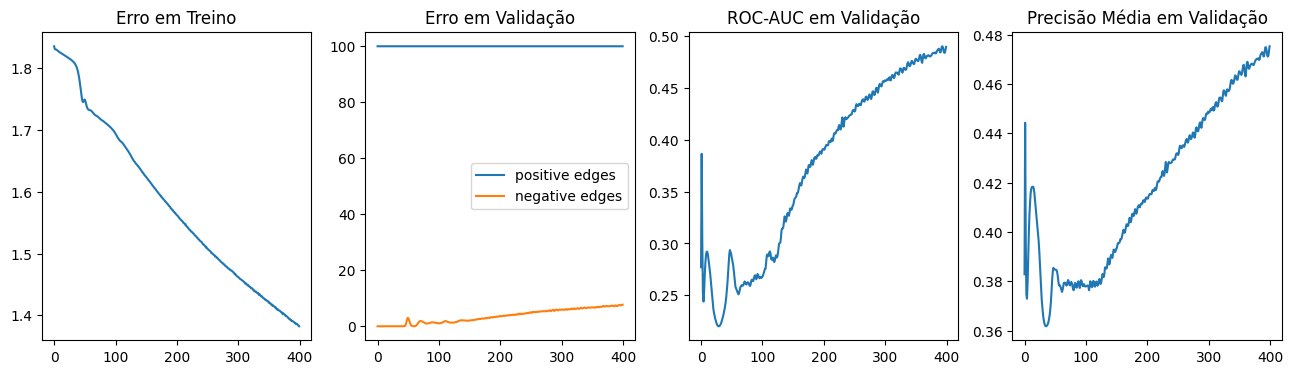

In [71]:
# Plots
fig, axs = plt.subplots(1, 4,  figsize=(16, 4))
axs[0].plot(history['loss'])
axs[0].set_title('Erro em Treino')
axs[1].plot(history['acc-pos'], label = 'positive edges')
axs[1].plot(history['acc-neg'], label = 'negative edges')
axs[1].set_title('Erro em Validação')
axs[1].legend()
axs[2].plot(history['val-roc'])
axs[2].set_title('ROC-AUC em Validação')
axs[3].plot(history['val-ap'])
axs[3].set_title('Precisão Média em Validação');

In [72]:
# Testando o modelo com dados de teste
test_roc, test_ap = dsa_testa_modelo(data, modelo_dsa, data["test_edges"], data["test_edges_neg"])

In [73]:
print(f"ROC-AUC em Teste: {test_roc:.4f}")
print(f"Precisão Média em Teste: {test_ap:.4f}")

ROC-AUC em Teste: 0.4931
Precisão Média em Teste: 0.5092


## Visualizando as Previsões

Vamos tentar visualizar a previsão da nossa rede em subconjuntos do grafo.

Você pode ajustar o `threshold`, o valor acima do qual consideramos uma aresta a ser prevista. Ao diminuí-lo, recuperamos mais arestas (Verdadeiros Positivos), correndo o risco de mais Falsos Positivos.

In [74]:
# Número de nós a serem mantidos para a visualização, mantenha-o pequeno para melhor visualização
N = 100  

In [75]:
# Limite para previsão de aresta
threshold = 0.9  

In [76]:
# Função para visualizar a previsão
def dsa_visualiza_previsao(graph, N, data, model, threshold = 0.5):
    
    # Ground-truth (grafo verdadeiro de referência)
    nodelist = np.random.permutation(graph.nodes())[:N]
    subgraph = graph.subgraph(nodelist).copy()
    subgraph.remove_edges_from(list(nx.selfloop_edges(subgraph)))  # remove laços para visualização
    subgraph.remove_nodes_from(list(nx.isolates(subgraph)))        # remove nós isolados para visualização
    print(subgraph)
    pos = nx.spring_layout(subgraph, iterations = 25)

    # Predição de arestas
    model.eval()
    pred_adj = model(data['x_train'], data['adj_train']).detach()
    pred_adj = torch.sigmoid(pred_adj) > threshold
    pred_edges = dsa_get_edge_index(pred_adj.detach().numpy())
    
    # Constrói um subgrafo a partir das arestas preditas
    subgraph_pred = nx.Graph()
    subgraph_pred.add_nodes_from(subgraph.nodes())
    nodes, subnodes = list(graph.nodes), set(subgraph.nodes())
    #print(nodes)
    
    subgraph_pred.add_edges_from([(nodes[pred_edges[0][i]], 
                                   nodes[pred_edges[1][i]]) for i in range(pred_edges.shape[1])
                                  if nodes[pred_edges[0][i]] in subnodes and nodes[pred_edges[1][i]] in subnodes])
    
    subgraph_pred.remove_edges_from(list(nx.selfloop_edges(subgraph_pred)))  
    
    print(f"{len(subgraph_pred.edges)} arestas previstas")

    # Plota os subgrafos com as arestas reais e previstas
    fig, axs = plt.subplots(1, 2, figsize = (8, 4))
    fig.suptitle('Subgrafo da Rede de Interação Proteína-Proteína\n')
    axs[0].set_title('Real')
    axs[1].set_title('Previsão')
    
    for edge_set, color in [(train_edges, 'C0'), (valid_edges, 'C1'), (test_edges, 'C2')]:
        
        edgelist = subgraph.edges(np.array(graph.nodes())[edge_set[0]])
        
        nx.draw_networkx(subgraph, 
                         pos, 
                         edgelist = edgelist, 
                         ax = axs[0], 
                         with_labels = False, 
                         node_size = 5, 
                         node_color = 'black', 
                         edge_color = color, 
                         width = 1., 
                         alpha = 0.5)
    
    nx.draw_networkx(subgraph_pred, 
                     pos, 
                     ax = axs[1], 
                     with_labels = False, 
                     node_size = 5, 
                     node_color = 'black', 
                     edge_color = 'C3', 
                     width = 1., 
                     alpha = 0.5)
    
    axs[0].legend([Line2D([], [], 
                          color = c, 
                          linewidth = 1., 
                          alpha=0.5) for c in ('C0', 'C1', 'C2')], ['treinamento', 'validação', 'teste'])
    
    axs[1].legend([Line2D([], [], 
                          color = 'C3', 
                          linewidth = 1., alpha = 0.5)], 
                  ['predição']);
    
    return fig

Graph with 74 nodes and 154 edges
333 arestas previstas


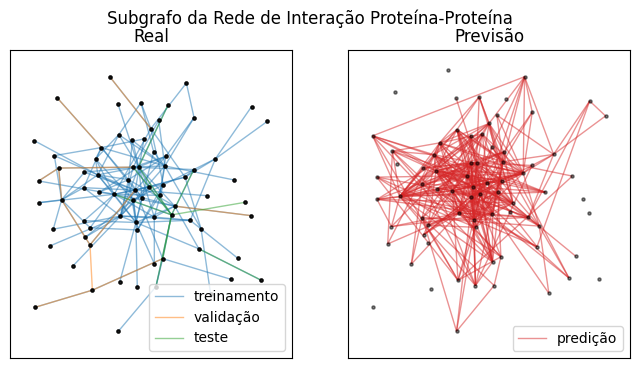

In [77]:
# Executa a função
resultado = dsa_visualiza_previsao(graph, N, data, modelo_dsa, threshold = threshold)

In [78]:
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [79]:
#%watermark -v -m

In [80]:
#%watermark --iversions

# Fim